# Generating Synthetic SCADA Datasets using GANs

Experiment with a very basic General Adversarial Network to generate SCADA synthetic dataset. 
Used EDP Open Data (https://opendata.edp.com/) on Wind Turbines. Dataset contains 80 features.

Used Keras and **2 Features**: Generator Frequency and Generator Volt Phase for simpler approach

**Obervations**:
With 2 features the synthetic dataset obtained is very similar to the real one. Oh Yeah!!

But...When using larger number of features Gradient Vanishement is observed (as noted in Ian GoodFellow's paper  https://arxiv.org/abs/1406.2661 ). Currently testing with Wassertein GAN (https://arxiv.org/abs/1701.07875)  implementation to solve this situation and generating more features.

# Results: 

## Sample Synthetic Generated SCADA messages

In [35]:
print("Synthetic Data set output (Created by GAN):")
dffake.head()

Synthetic Data set output (Created by GAN):


,Generator Prod Freq Avg,Generator Prod Volt Phase Avg
0,50.312412,405.223846
1,50.780399,407.293396
2,50.529289,406.151001
3,50.520802,405.467773
4,50.309952,404.176880


## Sample Real  SCADA messages from Dataset

In [36]:
print("Real Data set output from Dataset:")
dfreal.head()


Real Data set output from Dataset:


,Generator Prod Freq Avg,Generator Prod Volt Phase Avg
0,49.9,399.5
1,50.0,399.2
2,49.9,400.4
3,50.0,399.2
4,50.0,399.6


# Start of the Experiment

## Kick-off by testing a Potential Generator - Mix from several other ideas here and there

Using TensorFlow backend.






points generated (500,)
points generated rehsaped (100, 5)






output from generator:  (100, 8)
sample output for first element of array:  [-0.08188643 -0.29055625  0.49266326 -0.35142657  0.29799306  0.5941204
  0.44736674 -0.2630462 ]


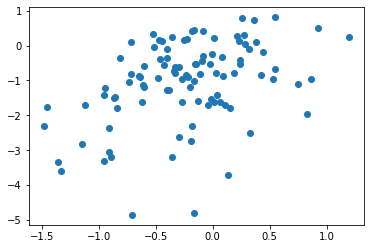

In [1]:
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot

# Let's think about 8 features

def define_generator(latent_dim, n_outputs=8):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    return model

def generate_init_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    print("points generated", x_input.shape)

    # reshape into a batch of inputs for the network        
    x_input = x_input.reshape(n, latent_dim)
    print("points generated rehsaped", x_input.shape)
    return x_input

# use the generator to generate n fake examples and plot the results
def generate_superfake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_init_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    print("output from generator: ",X.shape)
    print("sample output for first element of array: ",X[0])
    # plot the results for first and second features - it has generated 8 features
    pyplot.scatter(X[:, 0], X[:, 1])
    pyplot.show()

# size of the latent space
latent_dim = 5
# define the discriminator model
model = define_generator(latent_dim)
# generate and plot 100 generated samples
generate_superfake_samples(model, latent_dim, 100)

# Definitions and Imports

In [2]:
import numpy as np
from numpy import hstack
from numpy import zeros
from numpy import ones
from numpy.random import rand
from numpy.random import randn
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot
from sklearn.preprocessing import MinMaxScaler


# Load training Data

In [3]:
training_data = np.genfromtxt('wind-scada-2D-dataset-nolabels.csv', delimiter=';')


In [4]:
# Standarize between 1 and -1 (MinxMaxScalerfor easiness) 
estandarizar = MinMaxScaler(feature_range= (-1, 1))
norm_training_data = estandarizar.fit_transform(training_data)
norm_training_data = norm_training_data[:,:2]
print("Shape of training data: ",norm_training_data.shape)
print("Example vector: ",norm_training_data[1:4])


Shape of training data:  (207905, 2)
Example vector:  [[0.99600798 0.90231117]
 [0.99201597 0.90802954]
 [0.99600798 0.90231117]]


# Define models

In [5]:


# define the standalone discriminator model
def define_discriminator(n_inputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim=n_inputs))
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_outputs=2):
    model = Sequential()
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform', input_dim=latent_dim))
    model.add(Dense(n_outputs, activation='linear'))
    
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
    # make weights in the discriminator not trainable
    discriminator.trainable = False
    # connect them
    model = Sequential()
    # add generator
    model.add(generator)
    # add the discriminator
    model.add(discriminator)
    # compile model
    model.compile(loss='binary_crossentropy', optimizer='adam')
    return model


# Create the models 

# size of the latent space
latent_dim = 5
# create the discriminator
discriminator = define_discriminator()
discriminator.summary()
# create the generator
generator = define_generator(latent_dim)
generator.summary()
# create the gan
gan_model = define_gan(generator, discriminator)
gan_model.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 25)                75        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 26        
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 15)                90        
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 32        
Total params: 122
Trainable params: 122
Non-trainable params: 0
__________________________________________________

# Training Stage

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'




100/100 [==============================] - 0s 5ms/step
Epoch:  999  Disc Acc Real:  0.87  Disc Acc Fake 0.98


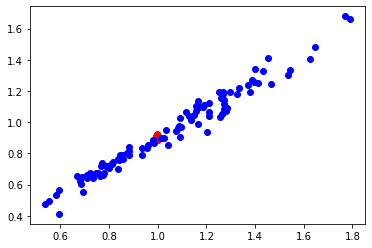

100/100 [==============================] - 0s 67us/step
Epoch:  1999  Disc Acc Real:  0.42  Disc Acc Fake 0.79


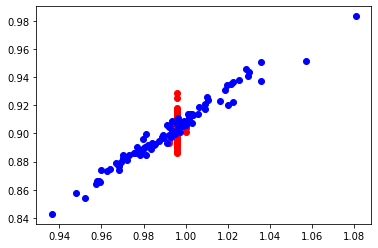

100/100 [==============================] - 0s 62us/step
Epoch:  2999  Disc Acc Real:  0.0  Disc Acc Fake 1.0


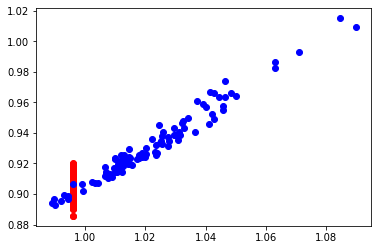

100/100 [==============================] - 0s 155us/step
Epoch:  3999  Disc Acc Real:  0.78  Disc Acc Fake 0.24


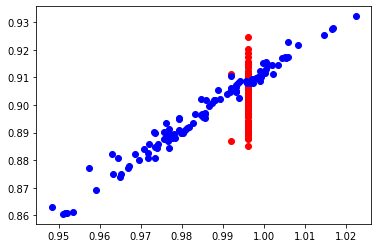

100/100 [==============================] - 0s 164us/step
Epoch:  4999  Disc Acc Real:  0.36  Disc Acc Fake 1.0


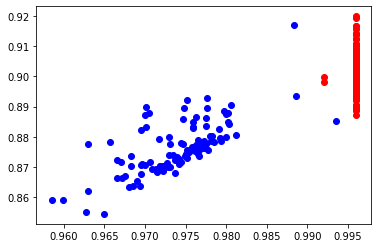

100/100 [==============================] - 0s 137us/step
Epoch:  5999  Disc Acc Real:  0.0  Disc Acc Fake 0.67


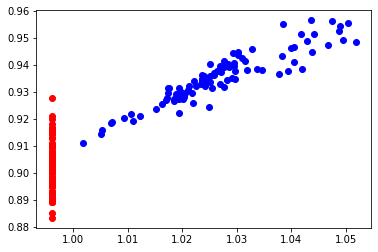

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-6-1a68f025c22c>", line 73, in <module>
    train(generator, discriminator, gan_model, latent_dim)
  File "<ipython-input-6-1a68f025c22c>", line 55, in train
    d_model.train_on_batch(x_real, y_real)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/engine/training.py", line 1217, in train_on_batch
    outputs = self.train_function(ins)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2715, in __call__
    return self._call(inputs)
  File "/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py", line 2675, in _call
    fetched = self._callable_fn(*array_vals)
  File "/home/ec2

KeyboardInterrupt: 

In [6]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

# evaluate the discriminator and plot real and fake points
def summarize_performance(epoch, generator, discriminator, latent_dim, n=100):
    # prepare real samples
    x_real = norm_training_data[np.random.randint(0, norm_training_data.shape[0], size=n), :]
    y_real = ones((n, 1))
    # evaluate discriminator on real examples
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose=1)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n)
    # evaluate discriminator on fake examples
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print("Epoch: ",epoch," Disc Acc Real: ", acc_real," Disc Acc Fake", acc_fake)
    #scatter plot real and fake data points
    pyplot.scatter(x_real[:, 0], x_real[:, 1], color='red')
    pyplot.scatter(x_fake[:, 0], x_fake[:, 1], color='blue')
    pyplot.show()

# train the generator and discriminator
def train(g_model, d_model, gan_model, latent_dim, n_epochs=40000, n_batch=128, n_eval=1000):
    
    
    # determine half the size of one batch, for updating the discriminator
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare real samples
        #x_real, y_real = generate_real_samples(half_batch)
        
        x_real = norm_training_data[np.random.randint(0, norm_training_data.shape[0], size=half_batch), :]
        y_real = ones((half_batch, 1))
        
        # prepare fake examples
        x_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

        # update discriminator
        d_model.train_on_batch(x_real, y_real)
        d_model.train_on_batch(x_fake, y_fake)
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)
        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))
        # update the generator via the discriminator's error
        ganstat = gan_model.train_on_batch(x_gan, y_gan)
        

        # evaluate the model every n_eval epochs
        if (i+1) % n_eval == 0:
            summarize_performance(i, g_model, d_model, latent_dim)

# size of the latent space
latent_dim = 5

# train model
train(generator, discriminator, gan_model, latent_dim)

# Obtain generator outputs

In [34]:
import numpy as np
import pandas as pd

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n):
    # generate points in the latent space
    x_input = randn(latent_dim * n)
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n, latent_dim)
    return x_input

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n)
    # predict outputs
    X = generator.predict(x_input)
    # create class labels
    y = zeros((n, 1))
    return X, y

latent_dim = 5
half_batch = 256

x_fake, y_fake = generate_fake_samples(generator, latent_dim, half_batch)

# now let's revert normalization
fake_dataset = estandarizar.inverse_transform(x_fake)
dffake = pd.DataFrame(data=fake_dataset)
dffake.columns = ['Generator Prod  Freq Avg', 'Generator Prod Volt Phase Avg']
dfreal = pd.DataFrame(data=training_data)
dfreal.columns = ['Generator Prod  Freq Avg', 'Generator Prod Volt Phase Avg']
dfreal.head()



,Generator Prod Freq Avg,Generator Prod Volt Phase Avg
0,49.9,399.5
1,50.0,399.2
2,49.9,400.4
3,50.0,399.2
4,50.0,399.6
